#Generar datos de entrenamiento segun los datos JS0000#

In [10]:
pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 18.5 MB/s eta 0:00:00


In [17]:
import wfdb
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import neurokit2 as nk

class ECGDatasetProcessor:
    def __init__(self, base_path="WFDBRecords"):
        self.base_path = base_path
        self.condition_mapping = self._load_condition_mapping()

    def _load_condition_mapping(self):
        """Carga el mapeo de condiciones SNOMED-CT"""
        try:
            condition_df = pd.read_csv('ConditionNames_SNOMED-CT.csv')
            mapping = {}
            for _, row in condition_df.iterrows():
                mapping[int(row['Snomed_CT'])] = {
                    'acronym': row['Acronym Name'],
                    'full_name': row['Full Name']
                }
            return mapping
        except:
            print("No se pudo cargar ConditionNames_SNOMED-CT.csv, usando mapeo básico")
            return {}

    def find_all_records(self):
        """Encuentra todos los archivos .hea en tu estructura específica"""
        record_paths = []
        print("Buscando archivos ECG...")

        # Tu estructura: WFDBRecords/01/JS#####.hea
        main_folder = "01"  # La carpeta donde están tus archivos

        folder_path = os.path.join(self.base_path, main_folder)
        if os.path.exists(folder_path):
            for file in os.listdir(folder_path):
                if file.endswith('.hea'):
                    record_id = file.replace('.hea', '')
                    full_path = os.path.join(folder_path, record_id)
                    record_paths.append(full_path)
                    print(f"Encontrado: {full_path}")

        print(f"Encontrados {len(record_paths)} archivos .hea")
        return record_paths

    def parse_header_file(self, header_path):
        """Parsea manualmente el archivo .hea para extraer metadatos"""
        metadata = {
            'age': 'Unknown',
            'gender': 'Unknown',
            'snomed_codes': [],
            'diagnoses': []
        }

        try:
            with open(header_path + '.hea', 'r', encoding='utf-8') as f:
                lines = f.readlines()

                # Líneas de comentarios
                for line in lines:
                    line = line.strip()
                    if line.startswith('#Age:'):
                        metadata['age'] = line.split(':')[1].strip()
                    elif line.startswith('#Sex:'):
                        metadata['gender'] = line.split(':')[1].strip()
                    elif line.startswith('#Dx:'):
                        codes_str = line.split(':')[1].strip()
                        if codes_str and codes_str != 'None':
                            try:
                                snomed_codes = [int(code.strip()) for code in codes_str.split(',')]
                                metadata['snomed_codes'] = snomed_codes
                                metadata['diagnoses'] = [self.condition_mapping.get(code, {}).get('acronym', f'UNK_{code}')
                                                        for code in snomed_codes]
                            except ValueError:
                                metadata['diagnoses'] = ['PARSE_ERROR']

        except Exception as e:
            print(f"Error parsing header {header_path}: {e}")

        return metadata

    def calculate_heart_rate(self, record_path):
        """Calcula la frecuencia cardiaca promedio de manera robusta"""
        try:
            # Cargar registro
            record = wfdb.rdrecord(record_path)
            signal = record.p_signal
            fs = record.fs

            # Seleccionar derivación
            try:
                lead_ii_index = record.sig_name.index('II')
                ecg_signal = signal[:, lead_ii_index]
            except ValueError:
                ecg_signal = signal[:, 0]  # Usar primera derivación

            # Limpiar señal
            ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs)

            # Detectar picos R con manejo de errores
            try:
                _, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs, correct_artifacts=True)
            except:
                return None, None

            if 'ECG_R_Peaks' not in rpeaks or len(rpeaks['ECG_R_Peaks']) < 2:
                return None, None

            # Calcular FC usando ecg_rate pero con validación
            heart_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(ecg_cleaned))

            # Filtrar valores absurdos
            valid_heart_rate = heart_rate[(heart_rate >= 30) & (heart_rate <= 200)]

            if len(valid_heart_rate) == 0:
                return None, None

            avg_heart_rate = np.mean(valid_heart_rate)

            # Validación final
            if 30 <= avg_heart_rate <= 200:
                if 60 <= avg_heart_rate <= 100:
                    rango = "Dentro"
                else:
                    rango = "Fuera"

                return round(avg_heart_rate, 2), rango
            else:
                return None, None

        except Exception as e:
            print(f"Error en {record_path}: {e}")
            return None, None

    def classify_rhythm(self, diagnoses_list):
        """Clasifica el ritmo cardiaco según las 4 categorías especificadas"""
        # Convertir a lista si es string
        if isinstance(diagnoses_list, str):
            diagnoses = diagnoses_list.split(',')
        else:
            diagnoses = diagnoses_list

        # Buscar las 4 categorías específicas
        target_rhythms = {
            'SB': 'Sinus Bradycardia',
            'SR': 'Sinus Rhythm',
            'AFIB': 'Atrial Fibrillation',
            'ST': 'Sinus Tachycardia'
        }

        # Verificar si tiene alguno de los ritmos objetivo
        for rhythm_code, rhythm_name in target_rhythms.items():
            if rhythm_code in diagnoses:
                return rhythm_name

        # Si no tiene ninguno de los ritmos objetivo, retornar "Otro"
        return "Otro"

    def create_training_dataset(self, output_csv="ecg_training_dataset.csv", sample_size=None):
        """Crea el dataset completo para entrenamiento"""
        record_paths = self.find_all_records()

        if not record_paths:
            print("❌ No se encontraron archivos .hea")
            print("Verifica la ruta de la carpeta WFDBRecords")
            return pd.DataFrame()

        if sample_size:
            record_paths = record_paths[:sample_size]

        dataset_rows = []

        print("Procesando registros ECG...")
        for record_path in tqdm(record_paths, desc="Procesando ECG"):
            try:
                # Extraer metadatos del header
                metadata = self.parse_header_file(record_path)

                # Calcular frecuencia cardiaca promedio y rango
                heart_rate, rango_cardiaco = self.calculate_heart_rate(record_path)

                # Clasificar el ritmo cardiaco
                ritmo_cardiaco = self.classify_rhythm(metadata['diagnoses'])

                # Crear fila del dataset
                row = {
                    'record_id': os.path.basename(record_path),
                    'age': metadata['age'],
                    'gender': metadata['gender'],
                    'snomed_codes': ','.join(map(str, metadata['snomed_codes'])),
                    'diagnoses': ','.join(metadata['diagnoses']),
                    'Frecuencia_Cardiaca_Promedio': heart_rate,
                    'Rango_cardiaco': rango_cardiaco,
                    'Ritmo_Cardiaco': ritmo_cardiaco
                }

                # Agregar columnas one-hot para diagnósticos comunes
                common_diagnoses = ['AFIB', 'SR', 'SB', 'RBBB', 'LBBB', 'APB', 'VPB', 'AF', 'ST']
                for dx in common_diagnoses:
                    row[f'dx_{dx}'] = 1 if dx in metadata['diagnoses'] else 0

                dataset_rows.append(row)

            except Exception as e:
                print(f"Error procesando {record_path}: {e}")
                continue

        # Crear DataFrame
        if dataset_rows:
            df = pd.DataFrame(dataset_rows)

            # ==================== 👇 NUEVO: ELIMINAR FILAS CON "Otro" 👇 ====================
            # Guardar conteo inicial
            total_inicial = len(df)

            # Filtrar solo las filas que NO tienen "Otro" en Ritmo_Cardiaco
            df_filtrado = df[df['Ritmo_Cardiaco'] != 'Otro'].copy()

            # Contar cuántas filas se eliminaron
            filas_eliminadas = total_inicial - len(df_filtrado)
            print(f"✅ Se eliminaron {filas_eliminadas} registros con Ritmo_Cardiaco = 'Otro'")
            print(f"✅ Registros restantes: {len(df_filtrado)}")
            # ==================== 👆 NUEVO: ELIMINAR FILAS CON "Otro" 👆 ====================

            # Guardar dataset filtrado
            df_filtrado.to_csv(output_csv, index=False)
            print(f"✅ Dataset guardado como {output_csv}")
            print(f"Total de registros procesados: {len(df_filtrado)}")

            # Mostrar estadísticas
            self._show_dataset_stats(df_filtrado)

            return df_filtrado
        else:
            print("❌ No se pudieron procesar registros")
            return pd.DataFrame()

    def _show_dataset_stats(self, df):
        """Muestra estadísticas del dataset"""
        print("\n=== ESTADÍSTICAS DEL DATASET ===")
        print(f"Total de registros: {len(df)}")

        if 'gender' in df.columns:
            print(f"Distribución por género:\n{df['gender'].value_counts()}")

        # Estadísticas de Frecuencia Cardiaca
        if 'Frecuencia_Cardiaca_Promedio' in df.columns and 'Rango_cardiaco' in df.columns:
            hr_data = df['Frecuencia_Cardiaca_Promedio'].dropna()
            rango_data = df['Rango_cardiaco'].dropna()

            if len(hr_data) > 0:
                print(f"\n📊 Estadísticas de Frecuencia Cardiaca:")
                print(f"  Promedio: {hr_data.mean():.2f} lpm")
                print(f"  Mínimo: {hr_data.min():.2f} lpm")
                print(f"  Máximo: {hr_data.max():.2f} lpm")
                print(f"  Desviación estándar: {hr_data.std():.2f} lpm")

                print(f"\n🚨 Alertas de Frecuencia Cardiaca (Rango 60-100 lpm):")
                dentro_count = len(rango_data[rango_data == "Dentro"])
                fuera_count = len(rango_data[rango_data == "Fuera"])
                total_valido = len(rango_data)

                if total_valido > 0:
                    print(f"  ✅ Dentro del rango normal: {dentro_count} ({dentro_count/total_valido*100:.1f}%)")
                    print(f"  ⚠️  Fuera del rango normal: {fuera_count} ({fuera_count/total_valido*100:.1f}%)")

                # Detalle de frecuencias anormales
                fc_data = df[df['Rango_cardiaco'] == 'Fuera']['Frecuencia_Cardiaca_Promedio'].dropna()
                if len(fc_data) > 0:
                    bradycardia = fc_data[fc_data < 60]
                    tachycardia = fc_data[fc_data > 100]
                    print(f"    - Bradicardia (<60 lpm): {len(bradycardia)} registros")
                    print(f"    - Taquicardia (>100 lpm): {len(tachycardia)} registros")

        # Estadísticas de Ritmo Cardiaco
        if 'Ritmo_Cardiaco' in df.columns:
            print(f"\n🎯 Distribución de Ritmos Cardiacos:")
            rhythm_counts = df['Ritmo_Cardiaco'].value_counts()
            for rhythm, count in rhythm_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {rhythm}: {count} registros ({percentage:.1f}%)")

        # Contar diagnósticos
        all_diagnoses = []
        for diagnoses in df['diagnoses']:
            if diagnoses and diagnoses != '':
                all_diagnoses.extend(diagnoses.split(','))

        if all_diagnoses:
            print(f"\nTop 10 diagnósticos más comunes:")
            for dx, count in pd.Series(all_diagnoses).value_counts().head(10).items():
                print(f"  {dx}: {count} registros")

# Función simple para probar con un archivo específico
def test_single_file():
    """Prueba con un archivo específico"""
    test_file = "WFDBRecords/01/JS00001"

    if os.path.exists(test_file + ".hea"):
        print("📄 Contenido del archivo JS00001.hea:")
        with open(test_file + ".hea", 'r') as f:
            content = f.read()
            print(content)

        # Procesar metadatos
        processor = ECGDatasetProcessor()
        metadata = processor.parse_header_file(test_file)
        print("\n📊 Metadatos extraídos:")
        for key, value in metadata.items():
            print(f"  {key}: {value}")

        # Probar cálculo de frecuencia cardiaca
        print("\n❤️  Calculando frecuencia cardiaca...")
        heart_rate, rango = processor.calculate_heart_rate(test_file)
        if heart_rate is not None:
            print(f"  Frecuencia Cardiaca Promedio: {heart_rate:.2f} lpm")
            print(f"  Rango cardiaco: {rango}")

        # Probar clasificación de ritmo
        ritmo = processor.classify_rhythm(metadata['diagnoses'])
        print(f"  Ritmo Cardiaco: {ritmo}")

    else:
        print("❌ Archivo JS00001.hea no encontrado")

# Ejecutar el procesamiento
if __name__ == "__main__":
    print("🔍 Probando con un archivo primero...")
    test_single_file()

    print("\n" + "="*50)
    print("Iniciando procesamiento completo...")

    # Inicializar procesador
    processor = ECGDatasetProcessor("WFDBRecords")

    # Crear dataset
    dataset_df = processor.create_training_dataset(
        output_csv="ecg_classification_dataset.csv",
        sample_size=None  # Procesar todos los archivos
    )

    if not dataset_df.empty:
        print("\n✅ ¡Procesamiento completado!")
        print(f"Archivo CSV generado: ecg_classification_dataset.csv")
        print("\n📋 Vista previa del dataset:")
        print(dataset_df[['record_id', 'age', 'gender', 'Frecuencia_Cardiaca_Promedio', 'Rango_cardiaco', 'Ritmo_Cardiaco', 'diagnoses']].head())

        # Mostrar correlación entre FC y diagnósticos
        if 'Frecuencia_Cardiaca_Promedio' in dataset_df.columns and 'Ritmo_Cardiaco' in dataset_df.columns:
            print("\n📈 Correlación entre FC y Ritmos Cardiacos:")
            for rhythm in ['Sinus Bradycardia', 'Sinus Rhythm', 'Atrial Fibrillation', 'Sinus Tachycardia']:
                rhythm_patients = dataset_df[dataset_df['Ritmo_Cardiaco'] == rhythm]
                if len(rhythm_patients) > 0:
                    avg_fc = rhythm_patients['Frecuencia_Cardiaca_Promedio'].mean()
                    print(f"  {rhythm}: FC promedio = {avg_fc:.2f} lpm")

    else:
        print("❌ No se pudo crear el dataset")

🔍 Probando con un archivo primero...
📄 Contenido del archivo JS00001.hea:
JS00001 12 500 5000
JS00001.mat 16+24 1000/mV 16 0 -254 21756 0 I
JS00001.mat 16+24 1000/mV 16 0 264 -599 0 II
JS00001.mat 16+24 1000/mV 16 0 517 -22376 0 III
JS00001.mat 16+24 1000/mV 16 0 -5 28232 0 aVR
JS00001.mat 16+24 1000/mV 16 0 -386 16619 0 aVL
JS00001.mat 16+24 1000/mV 16 0 390 15121 0 aVF
JS00001.mat 16+24 1000/mV 16 0 -98 1568 0 V1
JS00001.mat 16+24 1000/mV 16 0 -312 -32761 0 V2
JS00001.mat 16+24 1000/mV 16 0 -98 32715 0 V3
JS00001.mat 16+24 1000/mV 16 0 810 15193 0 V4
JS00001.mat 16+24 1000/mV 16 0 810 14081 0 V5
JS00001.mat 16+24 1000/mV 16 0 527 32579 0 V6
#Age: 85
#Sex: Male
#Dx: 164889003,59118001,164934002
#Rx: Unknown
#Hx: Unknown
#Sx: Unknown


📊 Metadatos extraídos:
  age: 85
  gender: Male
  snomed_codes: [164889003, 59118001, 164934002]
  diagnoses: ['AFIB', 'RBBB', 'TWC']

❤️  Calculando frecuencia cardiaca...
  Frecuencia Cardiaca Promedio: 117.40 lpm
  Rango cardiaco: Fuera
  Ritmo Cardia

Procesando ECG: 100%|██████████| 100/100 [00:01<00:00, 75.79it/s]

✅ Se eliminaron 5 registros con Ritmo_Cardiaco = 'Otro'
✅ Registros restantes: 95
✅ Dataset guardado como ecg_classification_dataset.csv
Total de registros procesados: 95

=== ESTADÍSTICAS DEL DATASET ===
Total de registros: 95
Distribución por género:
gender
Male      61
Female    34
Name: count, dtype: int64

📊 Estadísticas de Frecuencia Cardiaca:
  Promedio: 73.36 lpm
  Mínimo: 46.15 lpm
  Máximo: 142.48 lpm
  Desviación estándar: 23.23 lpm

🚨 Alertas de Frecuencia Cardiaca (Rango 60-100 lpm):
  ✅ Dentro del rango normal: 32 (33.7%)
  ⚠️  Fuera del rango normal: 63 (66.3%)
    - Bradicardia (<60 lpm): 48 registros
    - Taquicardia (>100 lpm): 15 registros

🎯 Distribución de Ritmos Cardiacos:
  Sinus Bradycardia: 50 registros (52.6%)
  Atrial Fibrillation: 22 registros (23.2%)
  Sinus Rhythm: 13 registros (13.7%)
  Sinus Tachycardia: 10 registros (10.5%)

Top 10 diagnósticos más comunes:
  SB: 50 registros
  AFIB: 22 registros
  TWC: 15 registros
  UNK_55827005: 14 registros
  SR: 1

#Modelo de entrenamiento

🔍 Verificando dataset...
Filas: 95, Columnas: 17
✅ Frecuencia_Cardiaca_Promedio: 95 valores no nulos
✅ Rango_cardiaco: 95 valores no nulos
   Valores únicos: ['Fuera' 'Dentro']
✅ Ritmo_Cardiaco: 95 valores no nulos
   Valores únicos: ['Sinus Bradycardia' 'Atrial Fibrillation' 'Sinus Tachycardia'
 'Sinus Rhythm']

📋 Primeras 5 filas:
   Frecuencia_Cardiaca_Promedio Rango_cardiaco       Ritmo_Cardiaco
0                         59.08          Fuera    Sinus Bradycardia
1                         58.42          Fuera    Sinus Bradycardia
2                         60.87         Dentro    Sinus Bradycardia
3                         58.06          Fuera    Sinus Bradycardia
4                         56.37          Fuera  Atrial Fibrillation

🚀 Iniciando entrenamiento...
📊 Cargando dataset...
Dataset cargado: 95 registros
Registros válidos después de filtrar: 95
📊 Conteo por clase:
  Sinus Bradycardia: 50 muestras
  Atrial Fibrillation: 22 muestras
  Sinus Rhythm: 13 muestras
  Sinus Tachycardi

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 924 (3.61 KB)

 Trainable params: 860 (3.36 KB)

 Non-trainable params: 64 (256.00 B)

🚀 Entrenando modelo...
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.2075 - loss: 2.0787 - val_accuracy: 0.5000 - val_loss: 1.3934
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2725 - loss: 2.0403 - val_accuracy: 0.5000 - val_loss: 1.3775
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2608 - loss: 2.0099 - val_accuracy: 0.5000 - val_loss: 1.3612
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3438 - loss: 1.7857 - val_accuracy: 0.5000 - val_loss: 1.3461
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3554 - loss: 1.6483 - val_accuracy: 0.5000 - val_loss: 1.3323
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3633 - loss: 1.6743 - val_accuracy: 0.5000 - val_loss: 1.3180
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4263 - loss: 1.5639 - val_accuracy: 0.5000 - val_loss: 1.3047
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4333 - loss: 1.4257 - val_accuracy: 0.5

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


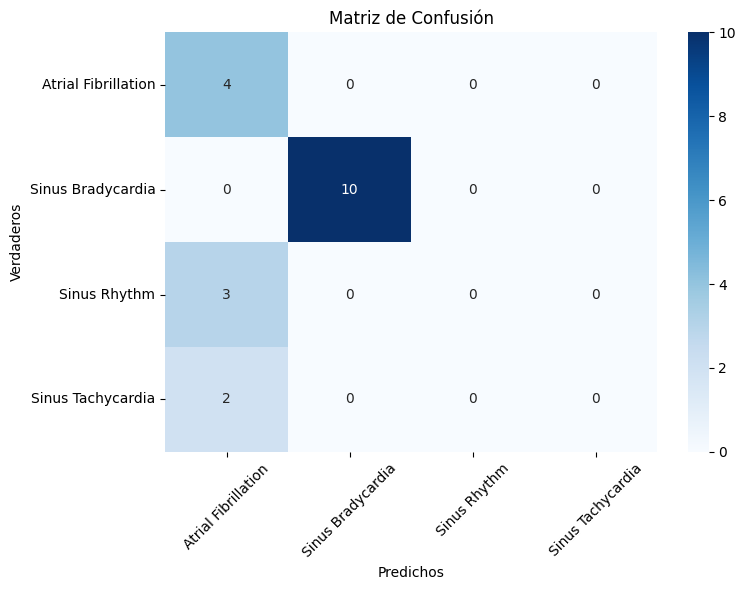

💾 Modelo guardado como 'ecg_classifier_heart_rate.h5'
💾 Label encoder guardado


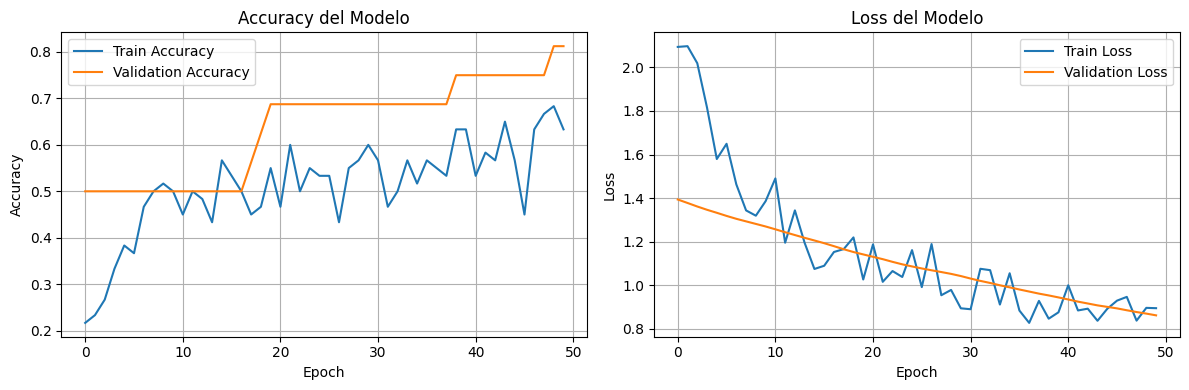


✅ Entrenamiento completado exitosamente!


In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

def train_model_heart_rate_features(csv_path):
    """Modelo usando Frecuencia_Cardiaca_Promedio y Rango_cardiaco como features"""
    try:
        df = pd.read_csv(csv_path)
        print(f"Dataset cargado: {len(df)} registros")
    except Exception as e:
        print(f"❌ Error cargando CSV: {e}")
        return None, None, None, None, None

    # Columnas necesarias
    required_columns = ['Frecuencia_Cardiaca_Promedio', 'Rango_cardiaco', 'Ritmo_Cardiaco']
    for col in required_columns:
        if col not in df.columns:
            return None, None, None, None, None

    df = df[df['Ritmo_Cardiaco'] != 'Otro'].copy()
    df = df.dropna(subset=required_columns).copy()

    print(f"Registros válidos después de filtrar: {len(df)}")

    # FEATURES
    X = df[['Frecuencia_Cardiaca_Promedio']].copy()

    X['Rango_cardiaco_encoded'] = df['Rango_cardiaco'].map({'Dentro': 1, 'Fuera': 0})

    y = df['Ritmo_Cardiaco'].copy()


    # Etiquetas de texto a numéricas
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Mapeo de clases para referencia
    class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
    print(f"🎯 Mapping de clases: {class_mapping}")

    # 4. Escalar features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"📦 Dimensiones finales:")
    print(f"Features (X): {X_scaled.shape}")
    print(f"Labels (y): {y_encoded.shape}")

    # Dividir datos
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
        )

        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
        )
    except Exception as e:
        print(f"❌ Error dividiendo datos: {e}")
        return None, None, None, None, None

    print(f"\n🎯 Distribución de clases en entrenamiento:")
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for cls_idx, count in zip(unique_classes, counts):
        class_name = label_encoder.inverse_transform([cls_idx])[0]
        print(f"  {class_name}: {count} muestras ({count/len(y_train)*100:.1f}%)")

    # 6. Crear modelo de red neuronal
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(16, activation='relu'),
        Dropout(0.3),

        Dense(8, activation='relu'),
        Dropout(0.2),

        Dense(len(np.unique(y_encoded)), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("🧠 Arquitectura del modelo:")
    model.summary()

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ]

    # 8. Entrenar modelo
    print("🚀 Entrenando modelo...")
    try:
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=50,  # Reducir epochs para prueba
            batch_size=16,  # Reducir batch size
            callbacks=callbacks,
            verbose=1
        )
    except Exception as e:
        print(f"❌ Error durante el entrenamiento: {e}")
        return None, None, None, None, None

    # 9. Evaluar modelo
    print("📊 Evaluando modelo...")
    try:
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"\n🎯 Resultados finales:")
        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Test Loss: {test_loss:.4f}")
    except Exception as e:
        print(f"❌ Error evaluando modelo: {e}")
        return model, history, X_test, y_test, label_encoder

    # 10. Predicciones y reporte
    try:
        y_pred = model.predict(X_test, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Convertir números de clase back a nombres
        y_true_names = label_encoder.inverse_transform(y_test)
        y_pred_names = label_encoder.inverse_transform(y_pred_classes)

        print("\n📋 Reporte de clasificación:")
        print(classification_report(y_true_names, y_pred_names))

        # Matriz de confusión
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_true_names, y_pred_names, labels=label_encoder.classes_)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=label_encoder.classes_,
                    yticklabels=label_encoder.classes_)
        plt.title('Matriz de Confusión')
        plt.ylabel('Verdaderos')
        plt.xlabel('Predichos')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')
        plt.show()

    except Exception as e:
        print(f"⚠️  Error generando reporte: {e}")

    # 11. Guardar modelo
    try:
        model.save('ecg_classifier_heart_rate.h5')
        print(f"💾 Modelo guardado como 'ecg_classifier_heart_rate.h5'")

        # Guardar el label encoder
        np.save('label_encoder_classes.npy', label_encoder.classes_)
        print(f"💾 Label encoder guardado")

    except Exception as e:
        print(f"⚠️  Error guardando modelo: {e}")

    # 12. Graficar historia de entrenamiento
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy del Modelo')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss del Modelo')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

    except Exception as e:
        print(f"⚠️  Error graficando historia: {e}")

    return model, history, X_test, y_test, label_encoder

# Función para diagnóstico de datos
def check_dataset(csv_path):
    """Verifica la calidad del dataset"""
    print("🔍 Verificando dataset...")
    try:
        df = pd.read_csv(csv_path)
        print(f"Filas: {len(df)}, Columnas: {len(df.columns)}")

        # Verificar columnas requeridas
        required_cols = ['Frecuencia_Cardiaca_Promedio', 'Rango_cardiaco', 'Ritmo_Cardiaco']
        for col in required_cols:
            if col in df.columns:
                print(f"✅ {col}: {df[col].notnull().sum()} valores no nulos")
                if df[col].dtype == 'object':
                    print(f"   Valores únicos: {df[col].unique()}")
            else:
                print(f"❌ {col}: NO ENCONTRADA")

        # Mostrar primeras filas
        print("\n📋 Primeras 5 filas:")
        print(df[required_cols].head())

        return True

    except Exception as e:
        print(f"❌ Error verificando dataset: {e}")
        return False

# Ejecutar entrenamiento
if __name__ == "__main__":
    # Primero verificar el dataset
    if check_dataset('ecg_classification_dataset.csv'):
        print("\n" + "="*50)
        print("Iniciando entrenamiento...")
        model, history, X_test, y_test, label_encoder = train_model_heart_rate_features('ecg_classification_dataset.csv')